### This has two datasets: an API dataset for SAIPE to get general poverty estimates and metrics (which is what is currently used to determine Title I funding) and Title I funding per district from the education department. 

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

# SAIPE API Data
The data here is from: https://www.census.gov/programs-surveys/saipe/data/api.html. The data here "provides annual estimates of income and poverty statistics for all school districts, counties, and states." In particular, the data pulled here will all be for children aged 5-17 because that is the demographic used to determine Title 1 funding.

***getSaipeDistrictData*** gets data for an individual school district in Lousiana for the pop. of children in poverty, the overall population of the district, and the poverty ratio between them (pop. in poverty / population * 100). This will be useful to join to other school district data / school data like graduation rates and district funding.

***getSaipeStateData*** gets data for an individual state (in this case Louisiana). This might not be super useful on its own, but it may be something useful to explore, potentially with other states, to see how some macro level poverty metrics change over time.

In [2]:
# ages are all from 5-17
def getSAIPEDistrictData(state = 22, start_year = 2017, end_year = 2022):
    url = "https://api.census.gov/data/timeseries/poverty/saipe/schdist"

    params = {
        "get": "SD_NAME,SAEPOV5_17RV_PT,SAEPOV5_17V_PT,SAEPOVRAT5_17RV_PT",
        "for": "school district (Unified):*",
        "in": f"state:{state}",
        "YEAR": f"{start_year}:{end_year}",
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data[1:], columns=["District Name","Pop. in Poverty","Population","Poverty Ratio Estimate","Year","State Code","District Code"]) 
        df[["Pop. in Poverty","Population","Poverty Ratio Estimate"]] = df[["Pop. in Poverty","Population","Poverty Ratio Estimate"]].apply(pd.to_numeric)
        return df
    else:
        print("API request failed with status code:", response.status_code)

In [3]:
# This would be useful to join with data for the actual funding for the school district + their graduation rates for a school in the district
lousiana_sd_df = getSAIPEDistrictData()
lousiana_sd_df.head()

,District Name,Pop. in Poverty,Population,Poverty Ratio Estimate,Year,State Code,District Code
0,Acadia Parish School District,4202,11885,35.4,2017,22,00030
1,Zachary Community School District,725,4456,16.3,2017,22,00039
2,Baker City School District,805,2829,28.5,2017,22,00040
3,Allen Parish School District,920,4141,22.2,2017,22,00060
4,Ascension Parish School District,3238,24493,13.2,2017,22,00090


In [4]:
lousiana_sd_df.describe().map(lambda x: f"{x:0.2f}")

,Pop. in Poverty,Population,Poverty Ratio Estimate
count,345.00,345.00,345.00
mean,2832.51,11462.59,27.22
std,3754.55,14721.05,8.85
min,151.00,676.00,9.70
25%,751.00,2829.00,21.40
50%,1377.00,5031.00,25.90
75%,3368.00,11746.00,32.20
max,20495.00,69523.00,64.00


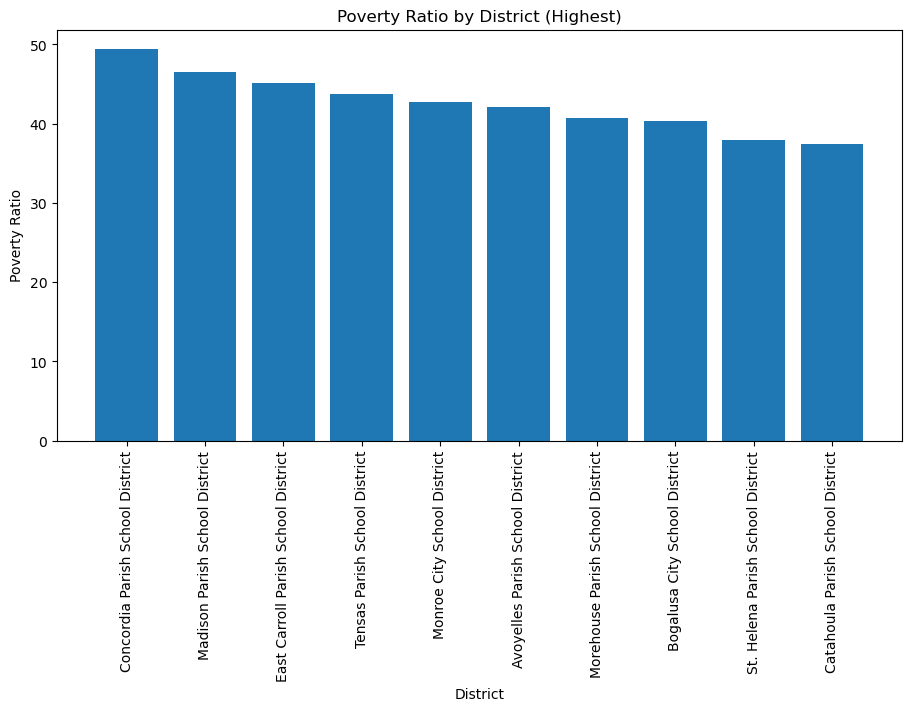

In [5]:
saipe2021 = lousiana_sd_df[lousiana_sd_df['Year'] == "2021"]
sorted_ratio = saipe2021.sort_values(by='Poverty Ratio Estimate', ascending=False).drop_duplicates()
sorted_ratio = sorted_ratio.iloc[:10]
fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
plt.xticks(rotation='vertical')
ax.set_title("Poverty Ratio by District (Highest)")
ax.set_xlabel('District')
ax.set_ylabel('Poverty Ratio')
ax.bar(sorted_ratio['District Name'], sorted_ratio['Poverty Ratio Estimate'])
plt.savefig('saipe_funding_visualizations/pov_ratio_highest.png', dpi=300, bbox_inches='tight')

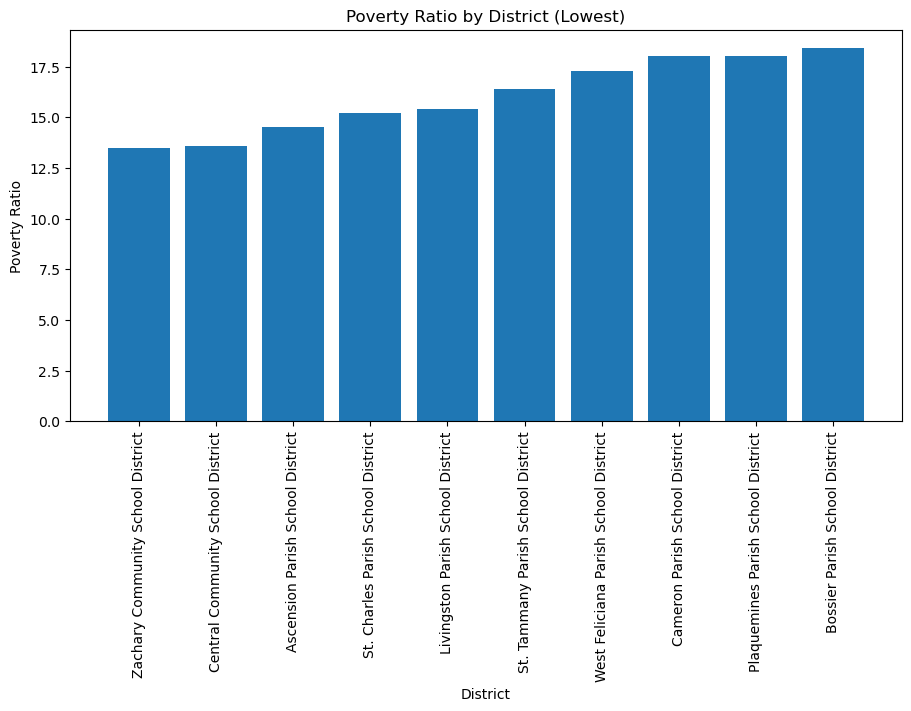

In [6]:
sorted_ratio_low = saipe2021.sort_values(by='Poverty Ratio Estimate', ascending=True).drop_duplicates()
sorted_ratio_low = sorted_ratio_low.iloc[:10]
fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
plt.xticks(rotation='vertical')
ax.set_title("Poverty Ratio by District (Lowest)")
ax.set_xlabel('District')
ax.set_ylabel('Poverty Ratio')
ax.bar(sorted_ratio_low['District Name'], sorted_ratio_low['Poverty Ratio Estimate'])
plt.savefig('saipe_funding_visualizations/pov_ratio_lowest.png', dpi=300, bbox_inches='tight')

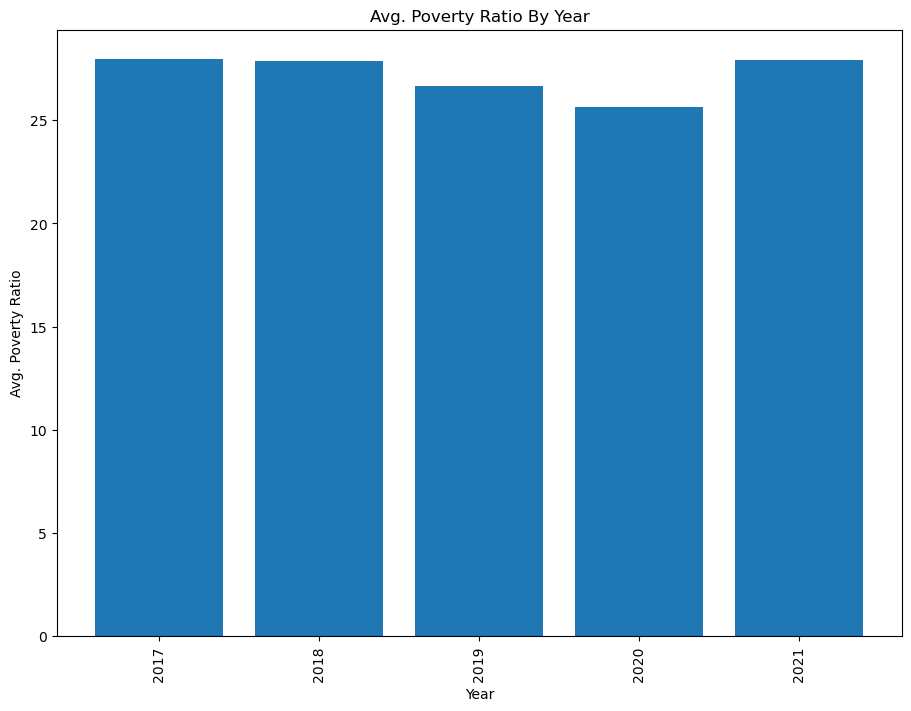

In [7]:
def meanYearSaipe(year = "2020"):
    temp = lousiana_sd_df[lousiana_sd_df['Year'] == year]
    return np.mean(temp['Poverty Ratio Estimate'])
fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
plt.xticks(rotation='vertical')
ax.set_title("Avg. Poverty Ratio By Year")
ax.set_xlabel('Year')
ax.set_ylabel('Avg. Poverty Ratio')
ax.bar(["2017","2018","2019","2020","2021"], [meanYearSaipe(x) for x in ["2017","2018","2019","2020","2021"]])
plt.savefig('saipe_funding_visualizations/pov_ratio_by_year.png', dpi=300, bbox_inches='tight')

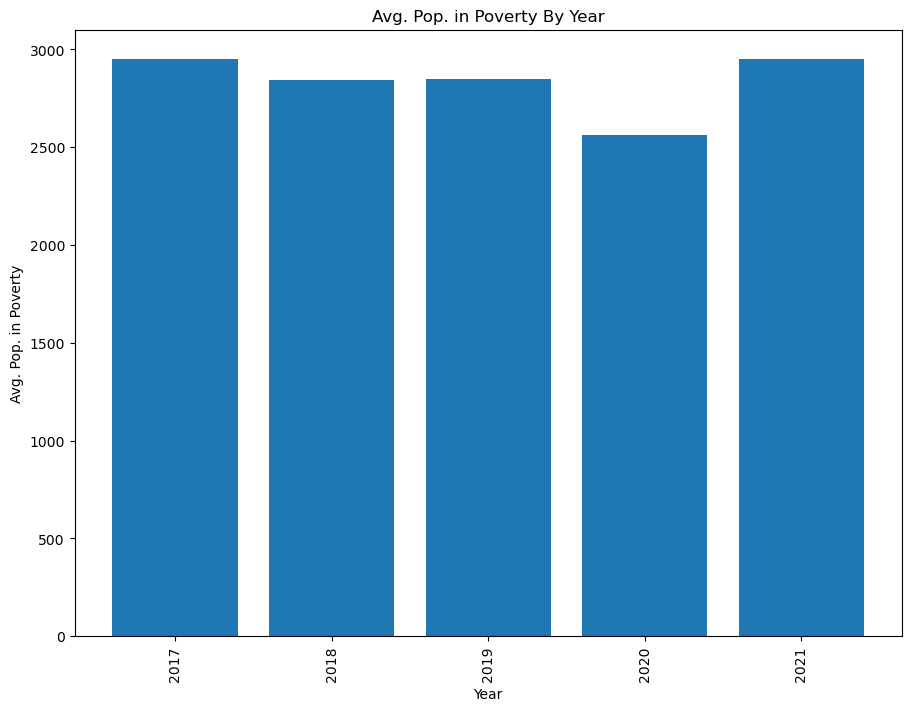

In [8]:
def meanYearSaipe(year = "2020"):
    temp = lousiana_sd_df[lousiana_sd_df['Year'] == year]
    return np.mean(temp['Pop. in Poverty'])
fig, ax = plt.subplots(figsize=(9, 7), layout='constrained')
plt.xticks(rotation='vertical')
ax.set_title("Avg. Pop. in Poverty By Year")
ax.set_xlabel('Year')
ax.set_ylabel('Avg. Pop. in Poverty')
ax.bar(["2017","2018","2019","2020","2021"], [meanYearSaipe(x) for x in ["2017","2018","2019","2020","2021"]])
plt.savefig('saipe_funding_visualizations/pov_pop_by_year.png', dpi=300, bbox_inches='tight')

In [9]:
# returns general poverty metrics for the state. Not sure if we will end up using this, but may be helpful to explore for some overall trends
# state 22 corresponds to Lousiana
# ages are all from 5-17
def getSAIPEStateData(state = 22,start_year = 2013, end_year = 2023):
    url = "https://api.census.gov/data/timeseries/poverty/saipe"

    params = {
        "get": "NAME,SAEPOV5_17R_PT,SAEPOV5_17R_MOE,SAEPOVRT5_17R_MOE,SAEPOVRT5_17R_PT,SAEMHI_PT",
        "for": f"state:{state}",
        "YEAR": f"{start_year}:{end_year}",
    }


    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data[1:], columns=["State Name","Count Estimate", "Count Estimate Margin of Error", "Poverty Rate Estimate", "Poverty Rate Estimate Margin of Error","Median Household Income","Year","State Code"]) 
        df[["Count Estimate", "Count Estimate Margin of Error", "Poverty Rate Estimate", "Poverty Rate Estimate Margin of Error","Median Household Income"]] = df[["Count Estimate", "Count Estimate Margin of Error", "Poverty Rate Estimate", "Poverty Rate Estimate Margin of Error","Median Household Income"]].apply(pd.to_numeric)

        return df
    else:
        print("API request failed with status code:", response.status_code)

In [10]:
lousiana_df = getSAIPEStateData()
lousiana_df.head()

,State Name,Count Estimate,Count Estimate Margin of Error,Poverty Rate Estimate,Poverty Rate Estimate Margin of Error,Median Household Income,Year,State Code
0,Louisiana,212904,8856,1.1,27.0,44234,2013,22
1,Louisiana,207577,7463,0.9,26.3,44680,2014,22
2,Louisiana,211026,7565,1.0,26.7,45829,2015,22
3,Louisiana,214016,8977,1.1,27.3,45374,2016,22
4,Louisiana,203606,8716,1.1,26.0,46283,2017,22


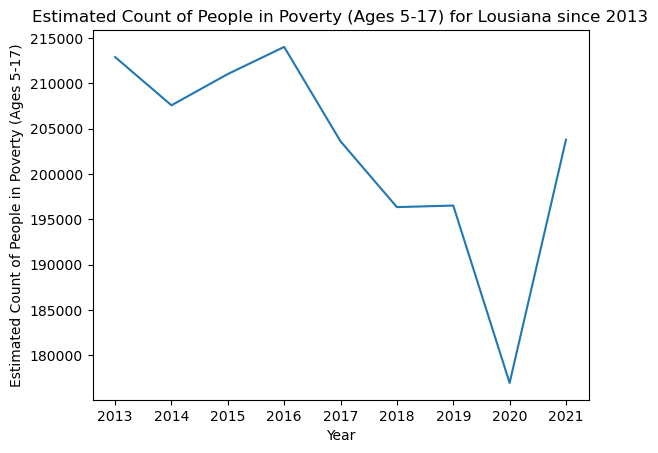

<Figure size 640x480 with 0 Axes>

In [11]:
plt.plot(lousiana_df['Year'], lousiana_df['Count Estimate'])
plt.xlabel('Year')
plt.ylabel('Estimated Count of People in Poverty (Ages 5-17)') 
plt.title('Estimated Count of People in Poverty (Ages 5-17) for Lousiana since 2013')
plt.show()
plt.savefig('saipe_funding_visualizations/title_I_student_count_over_time.png', dpi=300, bbox_inches='tight')

# Title 1 Funding per District
Data is from: https://www2.ed.gov/about/overview/budget/titlei/fy20/index.html (can access different years from there). This will give a general idea of the max funding allocated on a district (not school) level.

The website says: "FY 2020 Title I Allocations: Actual amounts received by LEAs will be smaller than shown here due to State-level adjustments to Federal Title I allocations. States adjust allocations, for example, to reflect LEA boundary changes or the creation of new LEAs, including charter school LEAs, that are not accounted for in the statutory calculations. States also are permitted to reserve, for administration, up to 1 percent of the allocations they would receive if $14 billion were appropriated and generally must reserve 7 percent of their allocations for school improvement. These adjustments will reduce the actual amounts available."

***getFundingDistributionMultipleYears*** can be used to get a dataframe with the Local Education Agency ID (LEA ID), District name, and the funding allocation for the years provided for Lousiana.

In [12]:
def getFundingDistribution(year=2020):
    if year > 2020 or year < 2002:
        print("no data")
        return
        
    if year == 2020:
        #the other years use xls file but it seems like 2020 has xlsx file for fun
        url="https://www2.ed.gov/about/overview/budget/titlei/fy20/louisiana.xlsx"
    else:
        url= f"https://www2.ed.gov/about/overview/budget/titlei/fy{year%2000}/louisiana.xls"
        
    funding_df=pd.read_excel(url, names=["LEA ID", "District Name", "Funding Allocation"])
    index_row = funding_df[funding_df.iloc[:, 0] == "LEA ID"].index.astype(int)[0]
    funding_df = funding_df.iloc[index_row+1:].dropna().iloc[:70]
    funding_df[["Funding Allocation"]] = funding_df[["Funding Allocation"]].apply(pd.to_numeric)

    return funding_df

# not very efficient way of doing this so it's a little slow
def getFundingDistributionMultipleYears(start_year = 2017, end_year = 2020):
    main_df = getFundingDistribution(start_year)
    for i in range(start_year+1,end_year+1):
        yearly_funding_df = getFundingDistribution(i)
        yearly_funding_df = yearly_funding_df.drop(columns = "District Name")
        main_df = main_df.merge(yearly_funding_df, on = "LEA ID", suffixes= ("",f" {i}"))
    main_df.rename(columns = {"Funding Allocation" : f"Funding Allocation {start_year}"},inplace=True)
    return main_df

In [13]:
lousiana_funds_per_district_df = getFundingDistributionMultipleYears()

In [14]:
lousiana_funds_per_district_df

,LEA ID,District Name,Funding Allocation 2017,Funding Allocation 2018,Funding Allocation 2019,Funding Allocation 2020
0,2200030,Acadia Parish School District,4.880192e+06,4.445567e+06,6.709748e+06,6.409416e+06
1,2200060,Allen Parish School District,1.212371e+06,1.334576e+06,1.239222e+06,1.143040e+06
2,2200090,Ascension Parish School District,4.398875e+06,4.338053e+06,4.548200e+06,4.878734e+06
3,2200120,Assumption Parish School District,1.074768e+06,1.427314e+06,1.328428e+06,1.444099e+06
4,2200150,Avoyelles Parish School District,3.160893e+06,3.607774e+06,3.426925e+06,4.380214e+06
...,...,...,...,...,...,...
65,2201950,West Carroll Parish School District,8.283318e+05,9.105190e+05,8.232964e+05,1.000507e+06
66,2201980,West Feliciana Parish School District,4.201066e+05,4.465322e+05,4.225473e+05,4.394120e+05
67,2202010,Winn Parish School District,8.695417e+05,9.766412e+05,9.705397e+05,8.734858e+05
68,2200039,Zachary Community School District,8.712029e+05,1.083274e+06,9.749465e+05,9.244421e+05


In [15]:
lousiana_funds_per_district_df.describe()

,Funding Allocation 2017,Funding Allocation 2018,Funding Allocation 2019,Funding Allocation 2020
count,7.000000e+01,7.000000e+01,7.000000e+01,7.000000e+01
mean,4.519888e+06,4.841576e+06,4.881318e+06,4.924341e+06
std,6.533636e+06,6.852538e+06,7.137749e+06,7.008131e+06
min,2.120097e+05,2.377868e+05,2.333543e+05,2.747856e+05
25%,1.117879e+06,1.194965e+06,1.234589e+06,1.166636e+06
50%,2.098271e+06,2.249802e+06,2.173057e+06,2.410420e+06
75%,4.759863e+06,4.434052e+06,5.057549e+06,5.325388e+06
max,3.448719e+07,3.504928e+07,3.748977e+07,3.615406e+07
